In [33]:
plt.rcParams["text.usetex"] = True

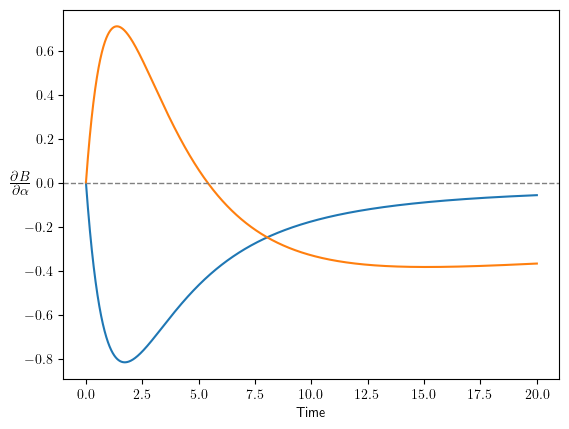

Final state x(t): [0.00165302 0.18296456]
Final Φ = dz/dz0:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [38]:
#Sensibilitat a alpha

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
rho1 = 0.6
rho2 = 0.125
alpha1 = 0.3
delta2 = 0.25
CC = 0.887
A = 2

def antibiotic_bacteria_from_z(z, rho1, rho2, delta2, CC, A):
    x = z[:2]
    alpha1 = z[2]
    BA = x[0] + x[1]
    dB_A_res = rho1 * x[0] * (1 - BA / CC) - alpha1 * A * x[0]
    dB_A_ses = rho2 * x[1] * (1 - BA / CC) + alpha1 * A * x[0] - delta2 *  (A/(1+A)) * x[1]
    return np.array([dB_A_res, dB_A_ses])

# Full Jacobian (3x3)
def full_jacobian(z, rho1, rho2, delta2, CC, A):
    x = z[:2]
    alpha1 = z[2]
    BA = x[0] + x[1]

    Jx = np.array([
        [rho1-(2*rho1/CC)*x[0]-(rho1/CC)*x[1]-alpha1*A, -(rho1/CC)*x[0]],
        [-(rho2/CC)*x[1]+alpha1*A, rho2-(2*rho2/CC)*x[1]-(rho2/CC)*x[0]-delta2* (A/(1+A))]
    ])
    Jalpha = np.array([
        [-A*x[0]],
        [+A*x[0]]
    ])

    J = np.zeros((3, 3))
    J[:2, :2] = Jx
    J[:2, 2] = Jalpha.flatten()
    return J

# Variational system
def variational(t, X, rho1, rho2, delta2, CC, A):
    n = 3  # Dimension of augmented state z = [x1, x2, alpha]
    z = X[:n]
    Phi = X[n:n + n**2].reshape((n, n))

    dzdt = np.zeros(n)
    dzdt[:2] = antibiotic_bacteria_from_z(z, rho1, rho2, delta2, CC, A)
    dzdt[2] = 0  # alpha' = 0

    J = full_jacobian(z, rho1, rho2, delta2, CC, A)
    dPhidt = J @ Phi
    return np.concatenate((dzdt, dPhidt.flatten()))

# Initial conditions
x0 = np.array([0.7, 0.3])
alpha_0 = alpha1
z0 = np.concatenate((x0, [alpha_0]))  # [x1, x2, alpha]
Phi0 = np.eye(3).flatten()
X0 = np.concatenate((z0, Phi0))

# Time span
t_span = (0, 20)
t_eval = np.linspace(*t_span, 5000)

# Solve
sol = solve_ivp(
    variational,
    t_span,
    X0,
    t_eval=t_eval,
    args=(rho1, rho2, delta2, CC, A),
    rtol=1e-14,
    atol=1e-14
)

# Extract solutions
x_sol = sol.y[:2, :]  # x1 and x2 over time
Phi_t = sol.y[3:, :].reshape(3, 3, -1)

# Extract sensitivity of x1, x2 with respect to alpha over time
dxd_delta2 = Phi_t[:2, 2, :]  # rows 0,1 (x1, x2); column 2 (alpha); all time points

# Plot
plt.figure()
plt.plot(sol.t, dxd_delta2[0], label=r'$\frac{\partial B^A}{\partial \alpha}$ (resistant)')
plt.plot(sol.t, dxd_delta2[1], label=r'$\frac{\partial B_A}{\partial \alpha}$ (sensitive)')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.locator_params(axis='y', nbins=10) 
plt.xlabel('Time', fontsize=10)
plt.ylabel(r'$\frac{\partial B}{\partial \alpha}$', rotation=0, fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.title('Sensitivity of Bacteria to alpha1 over time')
#plt.legend()
plt.savefig('Variational/cas2_alpha3.pdf')
plt.show()



# Final variational matrix
print("Final state x(t):", x_sol[:, -1])
print("Final Φ = dz/dz0:\n", Phi_t[:, :, 0])

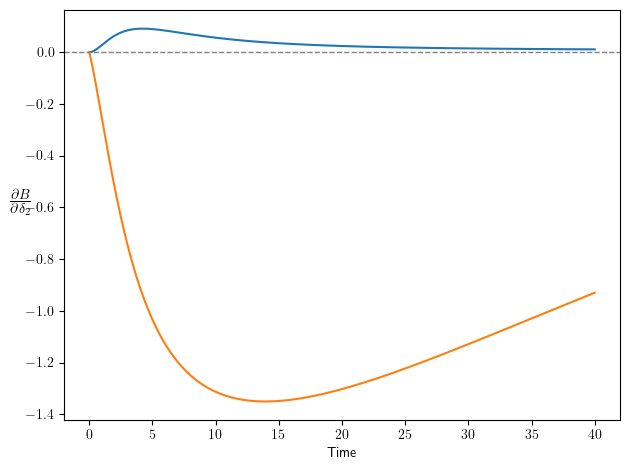

Final state x(t): [0.0003704  0.06302725]
Final Φ = dz/dz0:
 [[-2.62049628e-04 -3.83236559e-04  1.08997094e-02]
 [ 8.49435155e-04 -7.02252219e-03 -9.29926332e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
rho1 = 0.6
rho2 = 0.125
alpha1 = 0.3
delta2 = 0.25
CC = 0.887
A = 2

# System dynamics
def antibiotic_bacteria_from_z(z, rho1, rho2, alpha1, CC, A):
    x = z[:2]
    delta2 = z[2]
    BA = x[0] + x[1]
    dB_A_res = rho1 * x[0] * (1 - BA / CC) - alpha1 * A * x[0]
    dB_A_ses = rho2 * x[1] * (1 - BA / CC) + alpha1 * A * x[0] - delta2 * (A / (1 + A)) * x[1]
    return np.array([dB_A_res, dB_A_ses])

# Full Jacobian (3x3), for z = [x1, x2, delta2]
def full_jacobian(z, rho1, rho2, alpha1, CC, A):
    x = z[:2]
    delta2 = z[2]
    BA = x.sum()

    # Jacobian w.r.t. x1 and x2
    Jx = np.array([
        [rho1 * (1 - BA / CC) - rho1 * x[0] / CC - alpha1 * A, -rho1 * x[0] / CC],
        [alpha1 * A - rho2 * x[1] / CC, rho2 * (1 - BA / CC) - rho2 * x[1] / CC - delta2 * (A / (1 + A))]
    ])

    # Partial derivatives w.r.t delta2
    Jdelta = np.array([
        [0],
        [-(A / (1 + A)) * x[1]]
    ])

    # Combine
    J = np.zeros((3, 3))
    J[:2, :2] = Jx
    J[:2, 2] = Jdelta.flatten()
    return J

# Variational system
def variational(t, X, rho1, rho2, alpha1, CC, A):
    n = 3  # z = [x1, x2, delta2]
    z = X[:n]
    Phi = X[n:n + n**2].reshape((n, n))

    dzdt = np.zeros(n)
    dzdt[:2] = antibiotic_bacteria_from_z(z, rho1, rho2, alpha1, CC, A)
    dzdt[2] = 0  # delta2' = 0

    J = full_jacobian(z, rho1, rho2, alpha1, CC, A)
    dPhidt = J @ Phi
    return np.concatenate((dzdt, dPhidt.flatten()))

# Initial conditions
x0 = np.array([0.7, 0.3])
z0 = np.concatenate((x0, [delta2]))  # [x1, x2, delta2]
Phi0 = np.eye(3).flatten()
X0 = np.concatenate((z0, Phi0))

# Time span
t_span = (0, 40)
t_eval = np.linspace(*t_span, 5000)

# Solve
sol = solve_ivp(
    variational,
    t_span,
    X0,
    t_eval=t_eval,
    args=(rho1, rho2, alpha1, CC, A),
    rtol=1e-14,
    atol=1e-14
)

# Extract solutions
x_sol = sol.y[:2, :]
Phi_t = sol.y[3:, :].reshape(3, 3, -1)

# Extract sensitivities w.r.t delta2
dxd_delta2 = Phi_t[:2, 2, :]

# Plot
plt.figure()
plt.plot(sol.t, dxd_delta2[0], label=r'$\frac{\partial B^A}{\partial \delta_2}$ (resistant)')
plt.plot(sol.t, dxd_delta2[1], label=r'$\frac{\partial B_A}{\partial \delta_2}$ (sensitive)')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Time', fontsize=10)
plt.ylabel(r'$\frac{\partial B}{  \partial \delta_2}$', rotation=0, fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.legend()
#plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('Variational/sensitivity_delta2_3.pdf')
plt.show()

# Output final state
print("Final state x(t):", x_sol[:, -1])
print("Final Φ = dz/dz0:\n", Phi_t[:, :, -1])


/opt/anaconda3/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


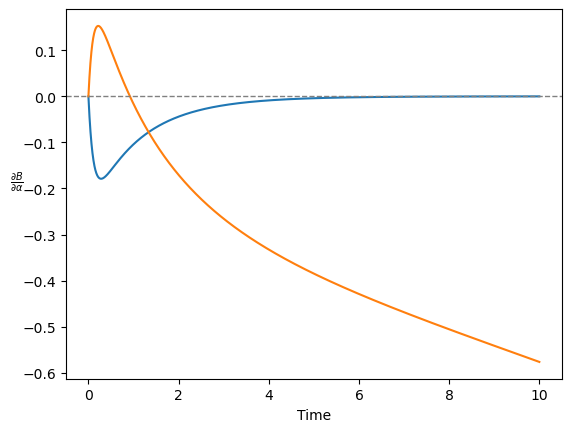

Final state x(t): [2.02954211e-39 2.63091330e-01]
Final Φ = dz/dz0:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
rho1 = 0.3
rho2 = 0.125
alpha1 = 0.3
delta2 = 0.25
CC = 0.887
A = 3




# System dynamics
def antibiotic_bacteria_from_z(z, rho1, rho2, delta2, CC, alpha1):
    x = z[:2]
    alpha1 = z[2]
    BA = x[0] + x[1]
    dB_A_res = rho1 * x[0] * (1 - BA / CC) - alpha1 * A * x[0]
    dB_A_ses = rho2 * x[1] * (1 - BA / CC) + alpha1 * A * x[0] - delta2 *  (A/(1+A)) * x[1]
    return np.array([dB_A_res, dB_A_ses])

# Full Jacobian (3x3)
def full_jacobian(z, rho1, rho2, delta2, CC, A):
    x = z[:2]
    alpha1 = z[2]
    BA = x[0] + x[1]

    Jx = np.array([
        [rho1-(2*rho1/CC)*x[0]-(rho1/CC)*x[1]-alpha1*A, -(rho1/CC)*x[0]],
        [-(rho2/CC)*x[1]+alpha1*A, rho2-(2*rho2/CC)*x[1]-(rho2/CC)*x[0]-delta2* (A/(1+A))]
    ])
    Jalpha = np.array([
        [-alpha1*x[0]],
        [+alpha1*x[0]-delta2*x[1]*(1/((1+A)**2))]
    ])

    J = np.zeros((3, 3))
    J[:2, :2] = Jx
    J[:2, 2] = Jalpha.flatten()
    return J

# Variational system
def variational(t, X, rho1, rho2, alpha1, CC, A):
    n = 3  # Dimension of augmented state z = [x1, x2, delta2]
    z = X[:n]
    Phi = X[n:n + n**2].reshape((n, n))

    dzdt = np.zeros(n)
    dzdt[:2] = antibiotic_bacteria_from_z(z, rho1, rho2, delta2, CC, A)
    dzdt[2] = 0  # delta2' = 0

    J = full_jacobian(z, rho1, rho2, delta2, CC, A)
    dPhidt = J @ Phi
    return np.concatenate((dzdt, dPhidt.flatten()))

# Initial conditions
x0 = np.array([0.7, 0.3])
antibiotic=A
z0 = np.concatenate((x0, [antibiotic]))  # [x1, x2, delta2]
Phi0 = np.eye(3).flatten()
X0 = np.concatenate((z0, Phi0))

# Time span
t_span = (0, 10)
t_eval = np.linspace(*t_span, 5000)

# Solve
sol = solve_ivp(
    variational,
    t_span,
    X0,
    t_eval=t_eval,
    args=(rho1, rho2, delta2, CC, alpha1),
    rtol=1e-14,
    atol=1e-14
)

# Extract solutions
x_sol = sol.y[:2, :]  # x1 and x2 over time
Phi_t = sol.y[3:, :].reshape(3, 3, -1)

# Extract sensitivity of x1, x2 with respect to delta2 over time
dxd_delta2 = Phi_t[:2, 2, :]  # rows 0,1 (x1, x2); column 2 (delta2); all time points

# Plot
plt.figure()
plt.plot(sol.t, dxd_delta2[0], label=r'$\frac{\partial B^A}{\partial \alpha}$ (resistant)')
plt.plot(sol.t, dxd_delta2[1], label=r'$\frac{\partial B_A}{\partial \alpha}$ (sensitive)')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.locator_params(axis='y', nbins=10)  # pots provar també 15 o 20 si vols més densitat
plt.xlabel('Time')
plt.ylabel(r'$\frac{\partial B}{\partial \alpha}$', rotation=0)
#plt.title('Sensitivity of Bacteria to alpha1 over time')
#plt.legend()
plt.savefig('Variational/cas3_coex_alpha.pdf')
plt.show()



# Final variational matrix
print("Final state x(t):", x_sol[:, -1])
print("Final Φ = dz/dz0:\n", Phi_t[:, :, 0])

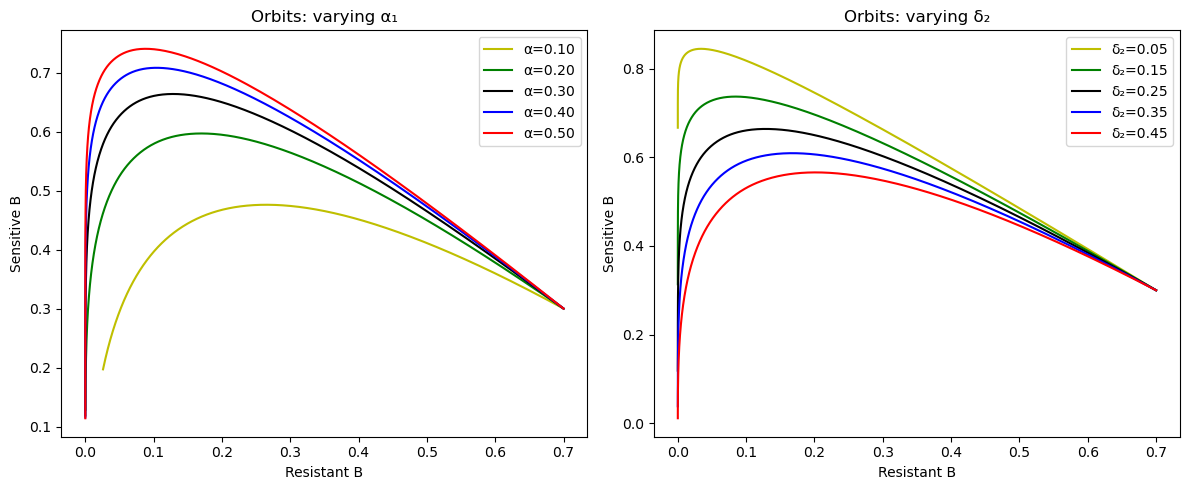

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# -- parameters & initial condition --
rho1, rho2 = 0.3, 0.125
CC, A = 0.887, 3.
x0 = np.array([0.7, 0.3])
t_span = (0, 20)
t_eval = np.linspace(*t_span, 2000)

# ODE for x = [resistant, sensitive]
def ode_x(t, x, rho1, rho2, alpha1, delta2, CC, A):
    BA = x.sum()
    dx1 = rho1*x[0]*(1-BA/CC) - alpha1*A*x[0]
    dx2 = rho2*x[1]*(1-BA/CC) + alpha1*A*x[0] - delta2*(A/(1+A))*x[1]
    return [dx1, dx2]

# -- choose parameter sets --
alpha_base, delta_base = 0.3, 0.25
alphas = [0.1, 0.2, alpha_base, 0.4, 0.5]
deltas = [0.05, 0.15, delta_base, 0.35, 0.45]
colors = ['y', 'g', 'k','b','r']

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# vary alpha
for α,c in zip(alphas, colors):
    sol = solve_ivp(ode_x, t_span, x0, t_eval=t_eval,
                    args=(rho1, rho2, α, delta_base, CC, A))
    ax1.plot(sol.y[0], sol.y[1], c, label=f'α={α:.2f}')
ax1.set_title('Orbits: varying α₁')
ax1.set_xlabel('Resistant B'); ax1.set_ylabel('Sensitive B')
ax1.legend()

# vary delta
for δ,c in zip(deltas, colors):
    sol = solve_ivp(ode_x, t_span, x0, t_eval=t_eval,
                    args=(rho1, rho2, alpha_base, δ, CC, A))
    ax2.plot(sol.y[0], sol.y[1], c, label=f'δ₂={δ:.2f}')
ax2.set_title('Orbits: varying δ₂')
ax2.set_xlabel('Resistant B'); ax2.set_ylabel('Sensitive B')
ax2.legend()

plt.tight_layout()
plt.show()


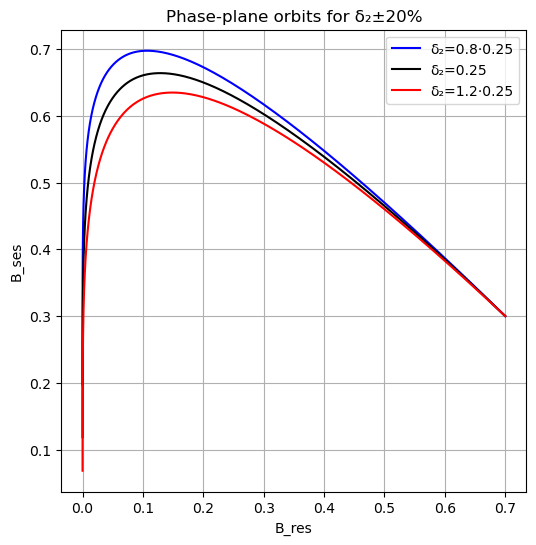

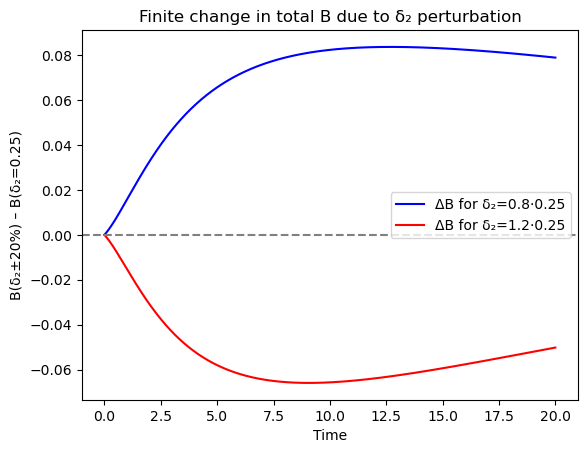

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# parameters
rho1, rho2 = 0.3, 0.125
CC, A = 0.887, 3.
alpha1, delta_base = 0.3, 0.25
x0 = np.array([0.7, 0.3])
t_span = (0, 20)
t_eval = np.linspace(*t_span, 2000)

def ode_x(t, x, rho1, rho2, alpha1, delta2, CC, A):
    BA = x.sum()
    dx1 = rho1*x[0]*(1-BA/CC) - alpha1*A*x[0]
    dx2 = rho2*x[1]*(1-BA/CC) + alpha1*A*x[0] - delta2*(A/(1+A))*x[1]
    return [dx1, dx2]

# prepare deltas ±20%
deltas = [delta_base*0.8, delta_base, delta_base*1.2]
labels  = [r'δ₂=0.8⋅0.25', 'δ₂=0.25', r'δ₂=1.2⋅0.25']
colors  = ['blue','black','red']

# store solutions
sols = []
for δ,c in zip(deltas, colors):
    sol = solve_ivp(ode_x, t_span, x0, t_eval=t_eval,
                    args=(rho1, rho2, alpha1, δ, CC, A))
    sols.append(sol)

# 1) Orbits in phase‐plane
plt.figure(figsize=(6,6))
for sol,lab,c in zip(sols, labels, colors):
    plt.plot(sol.y[0], sol.y[1], c, label=lab)
plt.xlabel('B_res'); plt.ylabel('B_ses')
plt.title('Phase‐plane orbits for δ₂±20%')
plt.legend()
plt.grid(True)
plt.show()

# 2) Finite difference in total bacteria
B_base = sols[1].y[0] + sols[1].y[1]
plt.figure()
for sol,lab,c in zip([sols[0],sols[2]],
                     [labels[0],labels[2]],
                     [colors[0],colors[2]]):
    B = sol.y[0] + sol.y[1]
    plt.plot(sol.t, B - B_base, c, label=f'ΔB for {lab}')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Time'); plt.ylabel('B(δ₂±20%) – B(δ₂=0.25)')
plt.title('Finite change in total B due to δ₂ perturbation')
plt.legend()
plt.show()


100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 22.08it/s]


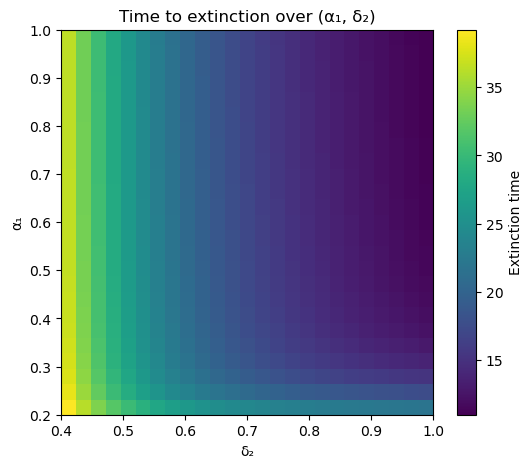

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm  # optional, for progress bar

# same ode_x as above

def extinction_time(alpha1, delta2, t_max=50, thresh=1e-3):
    sol = solve_ivp(ode_x, [0, t_max], x0, t_eval=np.linspace(0,t_max,5000),
                    args=(rho1, rho2, alpha1, delta2, CC, A))
    Btot = sol.y[0] + sol.y[1]
    below = np.where(Btot < thresh)[0]
    return sol.t[below[0]] if below.size>0 else t_max

# grid
alpha_vals = np.linspace(0.2, 1.0, 25)
delta_vals = np.linspace(0.4, 1.0, 25)
T = np.zeros((len(alpha_vals), len(delta_vals)))

for i,α in enumerate(tqdm(alpha_vals)):
    for j,δ in enumerate(delta_vals):
        T[i,j] = extinction_time(α, δ)

# plot
plt.figure(figsize=(6,5))
im = plt.imshow(T, 
                origin='lower', 
                extent=(delta_vals[0], delta_vals[-1], alpha_vals[0], alpha_vals[-1]),
                aspect='auto')
cbar = plt.colorbar(im)
cbar.set_label('Extinction time')
plt.xlabel('δ₂'); plt.ylabel('α₁')
plt.title('Time to extinction over (α₁, δ₂)')
plt.show()


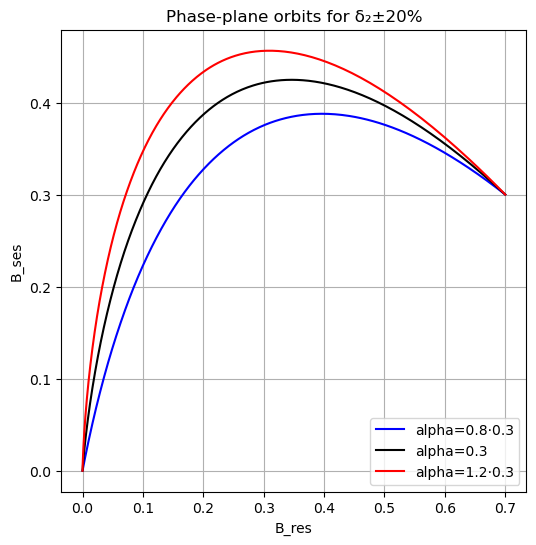

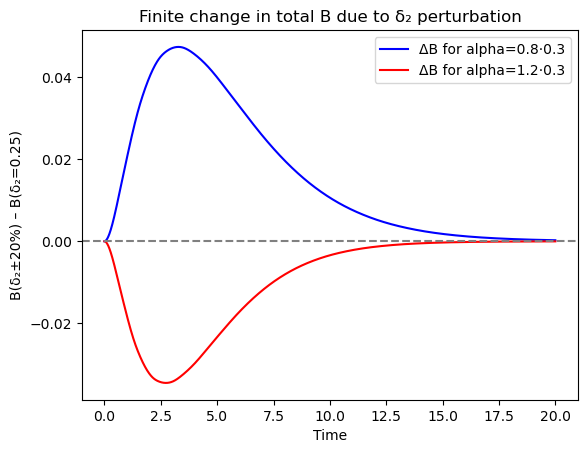

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# parameters
rho1, rho2 = 0.3, 0.125
CC, A = 0.887, 3.
alpha1, delta_base = 0.3, 0.25
x0 = np.array([0.7, 0.3])
t_span = (0, 20)
t_eval = np.linspace(*t_span, 2000)

def ode_x(t, x, rho1, rho2, alpha1, delta2, CC, A):
    BA = x.sum()
    dx1 = rho1*x[0]*(1-BA/CC) - alpha1*A*x[0]
    dx2 = rho2*x[1]*(1-BA/CC) + alpha1*A*x[0] - delta2*(A/(1+A))*x[1]
    return [dx1, dx2]

# prepare deltas ±20%
alphas = [alpha_base*0.8, alpha_base, alpha_base*1.2]
labels  = [r'alpha=0.8⋅0.3', 'alpha=0.3', r'alpha=1.2⋅0.3']
colors  = ['blue','black','red']

# store solutions
sols = []
for alpha,c in zip(alphas, colors):
    sol = solve_ivp(ode_x, t_span, x0, t_eval=t_eval,
                    args=(rho1, rho2, alpha, δ, CC, A))
    sols.append(sol)

# 1) Orbits in phase‐plane
plt.figure(figsize=(6,6))
for sol,lab,c in zip(sols, labels, colors):
    plt.plot(sol.y[0], sol.y[1], c, label=lab)
plt.xlabel('B_res'); plt.ylabel('B_ses')
plt.title('Phase‐plane orbits for δ₂±20%')
plt.legend()
plt.grid(True)
plt.show()

# 2) Finite difference in total bacteria
B_base = sols[1].y[0] + sols[1].y[1]
plt.figure()
for sol,lab,c in zip([sols[0],sols[2]],
                     [labels[0],labels[2]],
                     [colors[0],colors[2]]):
    B = sol.y[0] + sol.y[1]
    plt.plot(sol.t, B - B_base, c, label=f'ΔB for {lab}')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Time'); plt.ylabel('B(δ₂±20%) – B(δ₂=0.25)')
plt.title('Finite change in total B due to δ₂ perturbation')
plt.legend()
plt.show()

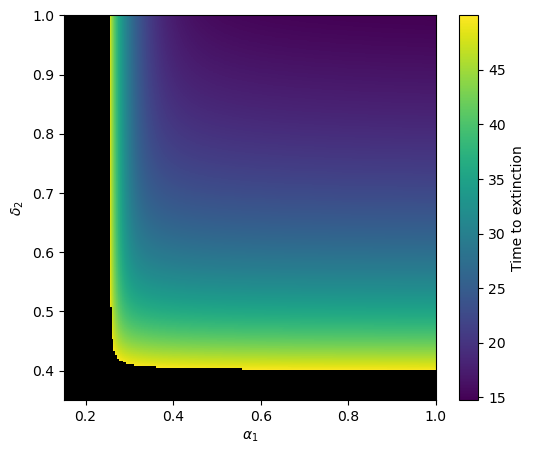

In [ ]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Fixed parameters with ONE FIXED INITIAL CONDITION
rho1, rho2 = 0.3, 0.125
CC, A = 0.887, 3.0
x0 = np.array([0.7, 0.3])
T_max = 50.0
thresh = 1e-4

def ode_x(t, x, rho1, rho2, alpha1, delta2, CC, A):
    BA = x.sum()
    dx1 = rho1*x[0]*(1-BA/CC) - alpha1*A*x[0]
    dx2 = rho2*x[1]*(1-BA/CC) + alpha1*A*x[0] - delta2*(A/(1+A))*x[1]
    return [dx1, dx2]

# extinction‐time function
def extinction_time(alpha1, delta2):
    sol = solve_ivp(
        ode_x, [0, T_max], x0,
        t_eval=np.linspace(0, T_max, 2000),
        args=(rho1, rho2, alpha1, delta2, CC, A),
        rtol=1e-8, atol=1e-10
    )
    Btot = sol.y[0] + sol.y[1]
    idx = np.where(Btot < thresh)[0]
    return sol.t[idx[0]] if idx.size else T_max

# build grid
alpha_vals = np.linspace(0.15, 1, 200)
delta_vals = np.linspace(0.35, 1, 200)
Tmat = np.zeros((alpha_vals.size, delta_vals.size))

# fill
for i, α in enumerate(alpha_vals):
    for j, δ in enumerate(delta_vals):
        Tmat[i,j] = extinction_time(α, δ)

# mask non‐extinct points
mask = (Tmat == T_max)
Tmat_masked = ma.masked_where(mask, Tmat)

# prepare colormap so that masked cells appear black
cmap = plt.cm.viridis.copy()
cmap.set_bad('black')

# plot heatmap
plt.figure(figsize=(6,5))
im = plt.imshow(
    Tmat_masked.T,
    origin='lower',
    extent=(alpha_vals[0], alpha_vals[-1],
            delta_vals[0], delta_vals[-1]),
    aspect='auto',
    cmap=cmap
)
cbar = plt.colorbar(im)
cbar.set_label('Time to extinction')
plt.xlabel(r'$\alpha_1$')
plt.ylabel(r'$\delta_2$')
plt.savefig()
plt.show()


